In [ ]:
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.cross_correlation import correlation_detector
from obspy.clients.fdsn.mass_downloader import Restrictions, MassDownloader, GlobalDomain

### ONLY RUN IF NOT ALREADY DOWNLOADED ###
# Mass download as mseed using Obspy
# From https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.mass_downloader.html#module-obspy.clients.fdsn.mass_downloader

start_time = obspy.UTCDateTime(2010, 12, 1)
mdl = MassDownloader(providers=['IRIS'])
domain = GlobalDomain()

for day in range(365): # Get data for XX days
    end_time = start_time + 3600*24
    restrictions = Restrictions(
        starttime=start_time,
        endtime=end_time,
        chunklength_in_sec=86400, #1 day chunks
        network="2C", station="IP18", location="*", channel="HH?",
        reject_channels_with_gaps=False,
        minimum_length=0.0,
        # Guard against same station having different names
        minimum_interstation_distance_in_m=100.0
        )
    mdl.download(domain, restrictions, mseed_storage="2CWaveforms",
                stationxml_storage="2Cstations")
   
    start_time += 3600 * 24 # Update to next day

In [ ]:
# Zachary Katz
# zachary_katz@mines.edu
# 07 November 2025

"""
Adaptation of MATH 532 Spatial Stats Final Project to demo Rmagic and Fields

Load catalog of GNSS events (soon to be stored in Earthscope)
Create velocity time series for each station
Perform kriging to interpolate velocity between stations using Fields

################################################################################
Notes on running R in Jupyter

Place this command before any R code
%load_ext rpy2.ipython 

Use %%R at the start of any R code cell or %R at the start of any R line
################################################################################
"""

# Imports and Extensions
import os
import datetime

import scipy
import numpy as np
import pandas as pd
import shapefile

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
import matplotlib.dates as mdates

# Run R commands in Jupyter
%load_ext rpy2.ipython 

#############################
## User-Defined Parameters ##

threshold = 50 # Contour Velocity For Nucleation [m/yr]
catalog_path= './_Data/' # Path to catalog

## User-Defined Parameters ##
#############################

def derivative(time, x_col, order, crit, spacing):
    """
    Compute the first and second derivative of a smoothed time series
    Parameters
    time - event with times
    x_col - column of x values of which to take the derivative of
    order - order of butterworth filter
    crit - critical value of butterworth filter
    spacing - spacing of gradient
    Returns
    grad - First derivative [list]
    """

    y_data = x_col - np.mean(x_col)

    # 1st derivative
    b, a = scipy.signal.butter(order, crit)
    filtered = scipy.signal.filtfilt(b, a, y_data, padlen=50)
    grad = np.gradient(filtered, spacing)
    return grad


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [25]:
%%R
# Install Fields package. Only need to run once
install.packages(c("fields", "spam"), repos='https://cloud.r-project.org', quiet=TRUE)

In [73]:
# Load catalog
catalog = []
for event in os.listdir(f"{catalog_path}"):
    catalog.append(pd.read_csv(f"{catalog_path}/{event}", sep="\t", index_col=0))

# Make velocity vectors
events_with_velocity = []

# Compute average second derivatives of all traces for each event
for event in catalog:
    event.dropna(inplace=True, axis=1)
    data = {"us": [], "vs": [], "xs": [], "ys": [], "times": [],'st_indices': []}

    x_cols = [col for col in event.columns if col.endswith("x")]
    y_cols = [col for col in event.columns if col.endswith("y")]
    
    # Remove all stations that don't have both x and y
    x_cols = [x for x in x_cols if x[:-1] + "y" in y_cols]
    y_cols = [y for y in y_cols if y[:-1] + "x" in x_cols]
    
    grad2s = []
    for x_col in x_cols:
        # Append x, u, t
        data_x = event[x_col]
        data['us'].append(derivative(event["time"], data_x, 4, 0.1, 15))
        data['xs'].append(data_x)
        data['times'].append(pd.to_datetime(event["time"]))

        # Compute 2nd derivative index
        grad = derivative(event["time"], event[x_col], 4, 0.1, 15)
        grad2 = derivative(event["time"], grad, 4, 0.05, 15)
        grad2s.append(grad2)
        

    avg_grad2 = np.nanmean(grad2s, axis=0)
    max_index = np.argmax(avg_grad2)
    data["st_indices"] = max_index

    for y_col in y_cols:
        # Append y, v
        data_y = event[y_col]
        data['vs'].append(derivative(event["time"], data_y, 4, 0.1, 15))
        data['ys'].append(data_y)

    events_with_velocity.append(data)


In [74]:
# Calculate nucleation position as coordinates of maximum velocity in the first
# frame where velocity is above a threshold (XX m/yr)
# Kriging Calculation mesh
x_min, x_max = -300000.0, -140000.0
y_min, y_max = -620000.0, -490000.0
gridx = np.arange(x_min,x_max, 500.0)
gridy = np.arange(y_min, y_max, 500.0)
x_len = len(gridx)
y_len = len(gridy)
xx,yy = np.meshgrid(gridx,gridy)

x_maxes = []
y_maxes = []
times = []
frame = []


for count, event in enumerate(events_with_velocity[:]): #Loop event
    print(count)
    # At each timestamp grid the velocity using kirging
    j = event['st_indices'] - 10
    found_nucleation = False
    while j < event['st_indices'] + 20 and j < len(event['xs'][0]) and j > 0:
        x = [event['xs'][i].iloc[j] for i in range(len(event['xs']))]
        y = [event['ys'][i].iloc[j] for i in range(len(event['ys']))]
        u = [event['us'][i][j] for i in range(len(event['us']))]
        v = [event['vs'][i][j] for i in range(len(event['vs']))]
        v_mag = [3600 * 24 *np.sqrt(u[i]*u[i] + v[i]*v[i]) for i in range(len(u))]
        
        X = np.array([x,y]).T
        y_prime = np.array(v_mag).reshape(-1,1)
        
        # Kriging in Fields
        %R -i X,y_prime,x_len,y_len -o surf,x_g,y_g 
        %R library(fields)
        %R obj <- spatialProcess(X, y_prime,smoothness=1, aRange=30000) #finer grid search, or fix aRange
        %R fit<- predictSurface( obj, nx=x_len, ny=y_len,extrap=TRUE)
        %R -o surf surf = fit$z
        %R -o x_g x_g=fit$x
        %R -o y_g y_g=fit$y
        
        max_v = np.max(surf)
        if max_v > threshold:
            frame.append(j)
            max_index = np.where(surf == max_v)
            j_max = j
            j = len(event['xs'][0])
            found_nucleation = True

        j = j + 1
      
    if found_nucleation:
        x_maxes.append(gridx[max_index[0][0]])
        y_maxes.append(gridy[max_index[1][0]])

0


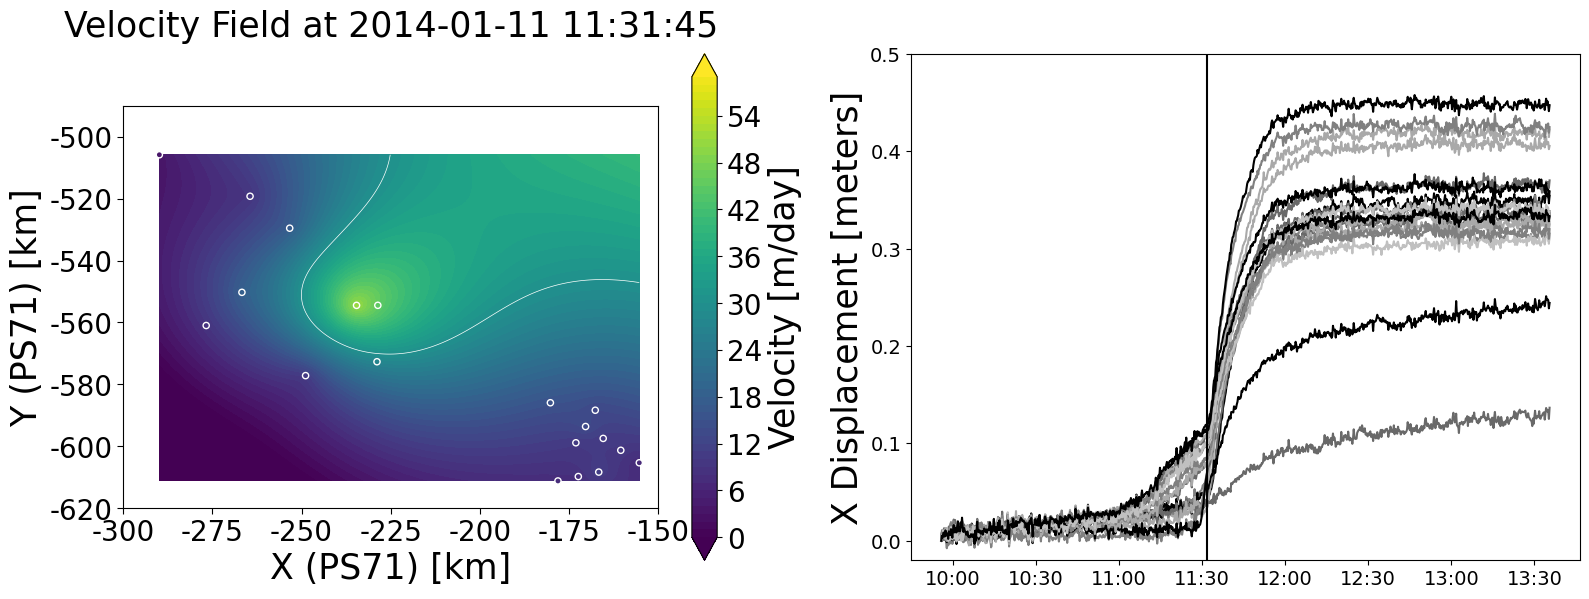

In [75]:
# Plot the frames found above
min_color = 0
max_color = 60

x_min, x_max = -300000.0,-150000.0
y_min, y_max = -620000.0, -490000.0
gridx = np.arange(x_min,x_max, 500.0)
gridy = np.arange(y_min, y_max, 500.0)
x_len = len(gridx)
y_len = len(gridy)
xx,yy = np.meshgrid(gridx,gridy)

for cnt, event in enumerate(events_with_velocity[:]): #Loop event
    # At each timestamp grid the velocity using kirging
    j = frame[count] 
    x = [event['xs'][i].iloc[j] for i in range(len(event['xs']))]
    y = [event['ys'][i].iloc[j] for i in range(len(event['ys']))]
    u = [event['us'][i][j] for i in range(len(event['us']))]
    v = [event['vs'][i][j] for i in range(len(event['vs']))]
    v_mag = [3600 * 24 *np.sqrt(u[i]*u[i] + v[i]*v[i]) for i in range(len(u))]
    
    X = np.array([x,y]).T
    y_prime = np.array(v_mag).reshape(-1,1)

    X = np.array([x,y]).T
    y_prime = np.array(v_mag).reshape(-1,1)

    # This needs to be on one line to be in the for loop :(
    %R -i xx,yy,X,y_prime,x_len,y_len -o surf,x_g,y_g library(fields); obj <- spatialProcess(X, y_prime,smoothness=0.5); fit<- predictSurface( obj, nx=x_len, ny=y_len,extrap=TRUE); surf = fit$z; x_g=fit$x; y_g=fit$y
        

    # Plot
    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(1,2,1, adjustable='box', aspect=((y_max-y_min)/(x_max-x_min)),)
    
    ax2 = fig.add_subplot(1,2,2)


    clr = ax.contourf(x_g, y_g, surf.T, levels=np.arange(min_color, max_color, 1), cmap='viridis',norm=mpl.colors.Normalize(vmin=min_color,vmax=max_color),extend='both')
    cbar = fig.colorbar(clr)
    cbar.set_label('Velocity [m/day]',size=25)
    cbar.ax.tick_params(labelsize=20)

    ax.contour(x_g, y_g, surf.T, levels=[30], colors='white', linewidths=0.5)

    ax.set_xlim(x_min,x_max)
    ax.set_ylim(y_min,y_max)
    KM_SCALE = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/KM_SCALE))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/KM_SCALE))
    ax.yaxis.set_major_formatter(ticks_y)
    ax.set_xlabel('X (PS71) [km]',size=25)
    ax.set_ylabel('Y (PS71) [km]',size=25)
    ax.tick_params(labelsize=20)
    ax.tick_params(size=4)

    ax.scatter(x,y,c=v_mag,s=20, norm=mpl.colors.Normalize(vmin=min_color,vmax=max_color),cmap='viridis',edgecolors='white')
    ax.set_title(f"Velocity Field at {event['times'][0].iloc[j]}",size=25, pad=50)

    first = True
    colors = ['black','dimgray','darkgray','gray','black','dimgray','darkgray','gray','black','dimgray','darkgray','gray','silver','black','dimgray','darkgray','gray','silver','black','dimgray','darkgray','gray','silver']
    for i, x_col in enumerate(event["xs"]):
        demeaned_to_0 = (x_col - np.mean(x_col)) - (
            x_col.iloc[0] - np.mean(x_col)
        )
        if not np.isnan(x_col).all():
            if first:
                ax2_dummy = demeaned_to_0
                first = False
            ax2.plot(event['times'][0], demeaned_to_0, color=colors[i])
    ax2.set_ylabel("X Displacement [meters]",size=25)
    
    ax2.vlines(event['times'][0].iloc[j],-0.5,10,color='black')
    ax2.set_ylim(-0.02,0.5)
    # Fix dates
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    # Setup dates using second axis

    ax2.tick_params(labelsize=14)

    
    fig.tight_layout()